In [25]:
!pip install umap-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

wine = load_wine()

X = wine.data
y = wine.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.cluster as cluster
import umap

reducers = [
    ('PCA', PCA(n_components=2)),
    ('TSNE', TSNE(n_components=2, random_state=42)),
    ('UMAP', umap.UMAP(n_components=2, random_state=42))
]

X_reduced_list = [(n, r.fit_transform(X_scaled)) for n, r in reducers]

In [28]:
import numpy as np


def run_clustering_algorithm(clustering_algorithm, X_reduced, target):
    labels = clustering_algorithm.fit_predict(X_reduced)
    ari = adjusted_rand_score(target, labels)
    if len(np.unique(labels)) == len(labels) or len(np.unique(labels)) == 1:
        silhouette = np.nan
    else:
        silhouette = silhouette_score(X_scaled, labels)
    return labels, ari, silhouette


def plot_clustering_result(X_reduced, labels, algorithm_name, ari, silhouette):
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='tab10')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(algorithm_name)
    legend_text = f'ARI: {ari:.2f}, Silhouette: {silhouette:.2f}'
    legend = plt.legend([legend_text], loc='lower right', handlelength=0)
    for handle in legend.legend_handles:
        handle.set_visible(False)
    plt.show()


def run_clustering(algorithms):
    for algorithm in algorithms:
        algorithm_arguments = algorithm.get_params()
        print(f'Algorithm: {algorithm}')
        print('Arguments:')
        for arg, value in algorithm_arguments.items():
            print(f'\t{arg}: {value}')

        for reducer_name, X_reduced in X_reduced_list:
            labels, ari, silhouette = run_clustering_algorithm(algorithm, X_reduced, y)
            plot_clustering_result(X_reduced, labels, str(algorithm) + ' - ' + reducer_name, ari,
                                   silhouette)

С точки зрения задания я решил использовать SpectralClustering и MeanShift для анализа

Остальные алгоритмы решил использовать для общего развития

Algorithm: Birch()
Arguments:
	branching_factor: 50
	compute_labels: True
	copy: True
	n_clusters: 3
	threshold: 0.5


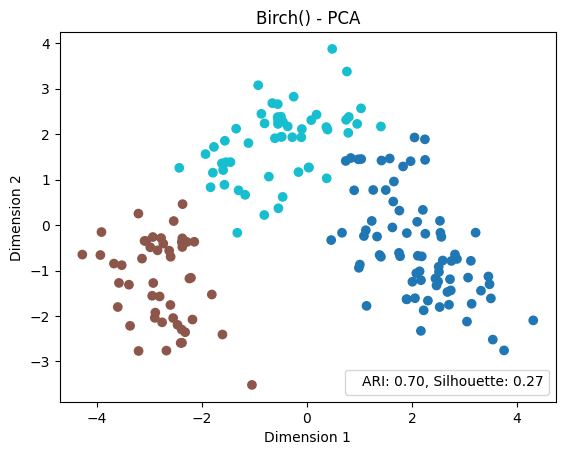

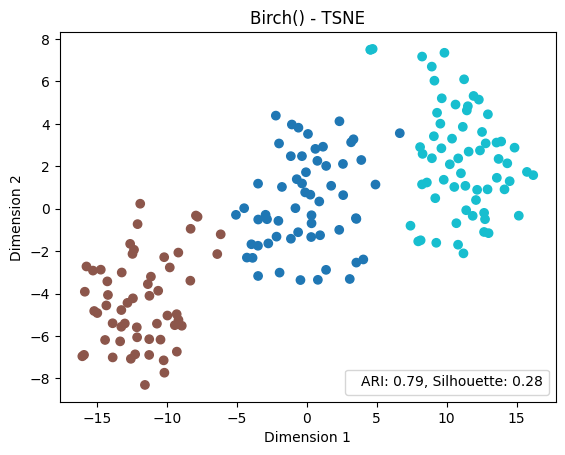

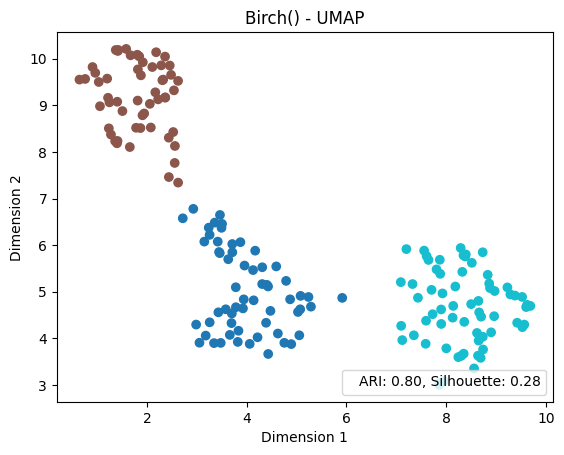

Algorithm: SpectralClustering(n_clusters=3)
Arguments:
	affinity: rbf
	assign_labels: kmeans
	coef0: 1
	degree: 3
	eigen_solver: None
	eigen_tol: auto
	gamma: 1.0
	kernel_params: None
	n_clusters: 3
	n_components: None
	n_init: 10
	n_jobs: None
	n_neighbors: 10
	random_state: None
	verbose: False


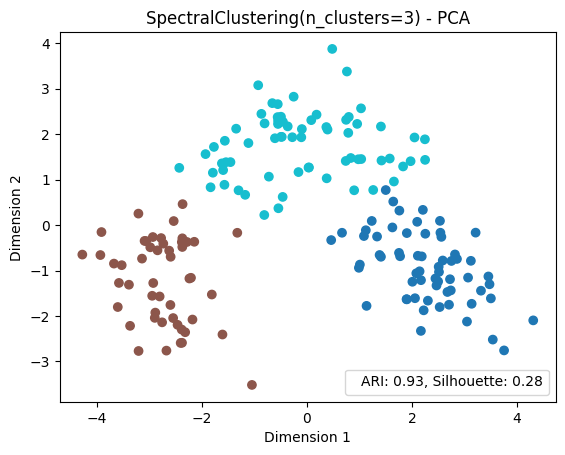

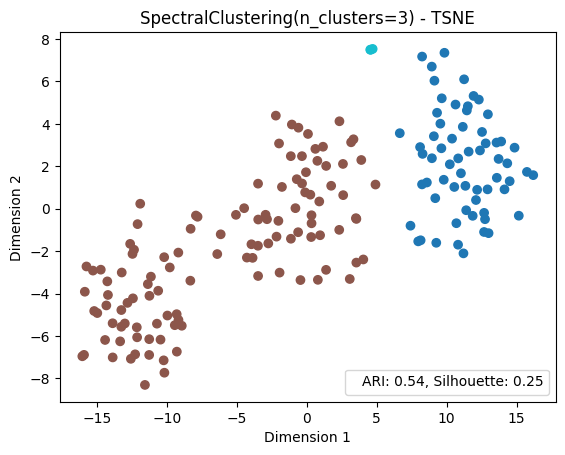

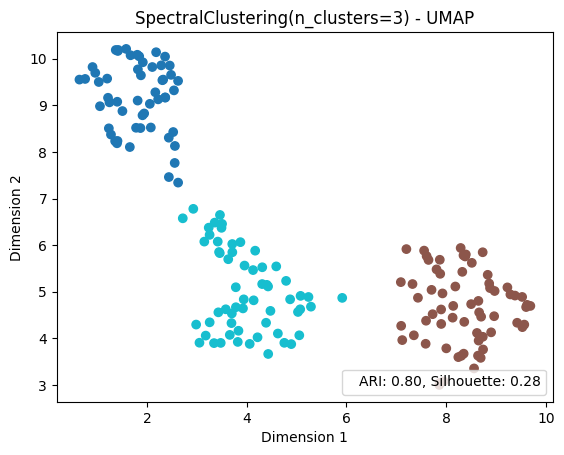

Algorithm: SpectralClustering(affinity='nearest_neighbors', n_clusters=3)
Arguments:
	affinity: nearest_neighbors
	assign_labels: kmeans
	coef0: 1
	degree: 3
	eigen_solver: None
	eigen_tol: auto
	gamma: 1.0
	kernel_params: None
	n_clusters: 3
	n_components: None
	n_init: 10
	n_jobs: None
	n_neighbors: 10
	random_state: None
	verbose: False


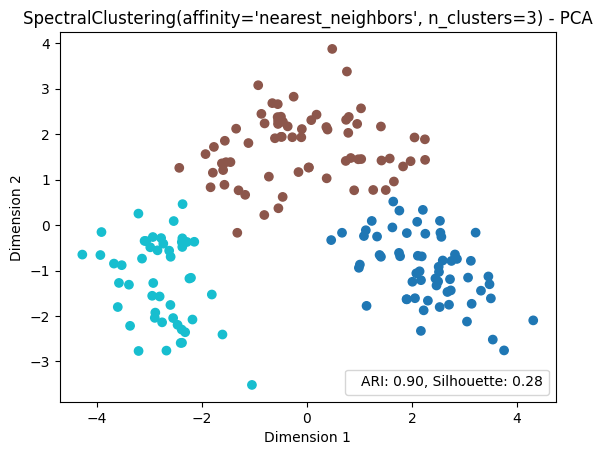

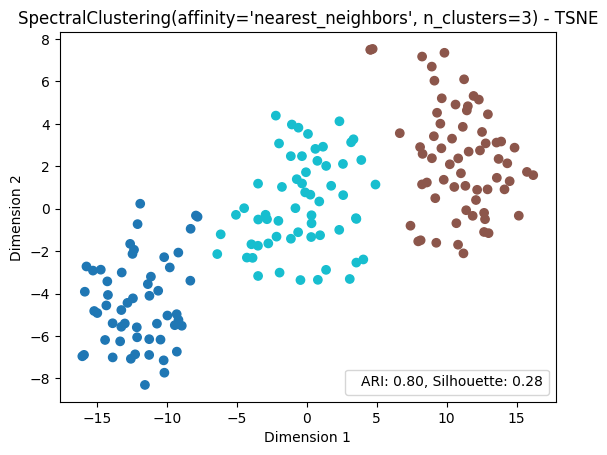

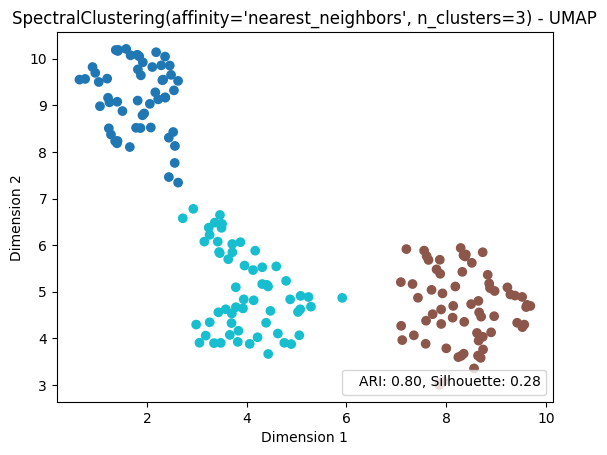

Algorithm: MiniBatchKMeans(n_clusters=3, n_init=10)
Arguments:
	batch_size: 1024
	compute_labels: True
	init: k-means++
	init_size: None
	max_iter: 100
	max_no_improvement: 10
	n_clusters: 3
	n_init: 10
	random_state: None
	reassignment_ratio: 0.01
	tol: 0.0
	verbose: 0


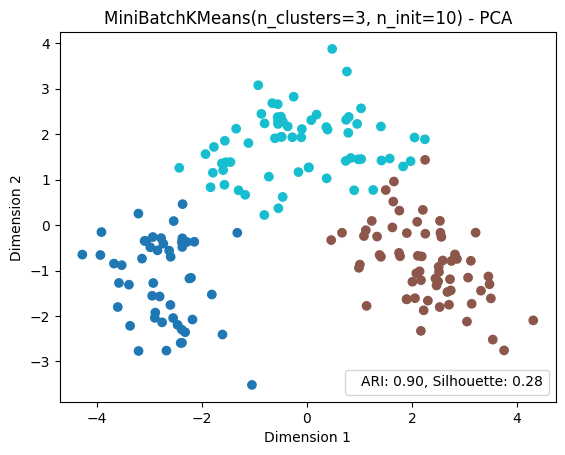

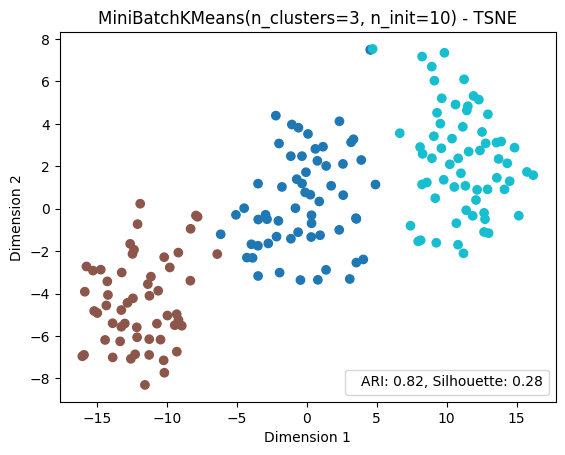

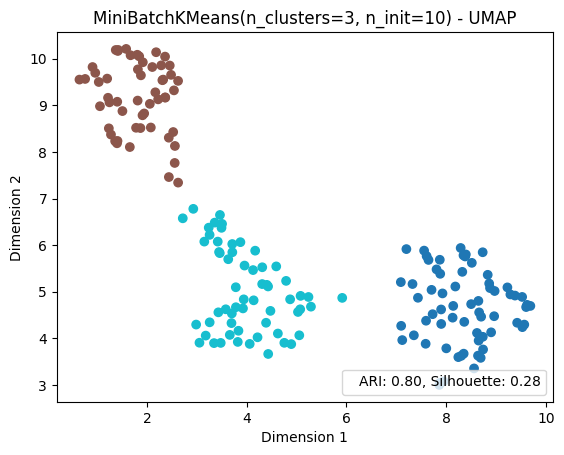

In [29]:
algorithms_with_n_clusters = [
    cluster.Birch(n_clusters=3, threshold=0.5),  # вставлено просто так

    cluster.SpectralClustering(n_clusters=3, affinity='rbf'),
    cluster.SpectralClustering(n_clusters=3, affinity='nearest_neighbors'),

    cluster.MiniBatchKMeans(n_clusters=3, n_init=10),  # вставлено просто так
]

run_clustering(algorithms_with_n_clusters)

Algorithm: DBSCAN()
Arguments:
	algorithm: auto
	eps: 0.5
	leaf_size: 30
	metric: euclidean
	metric_params: None
	min_samples: 5
	n_jobs: None
	p: None


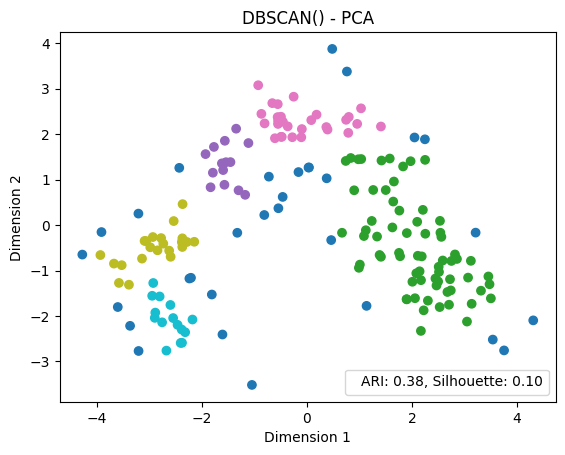

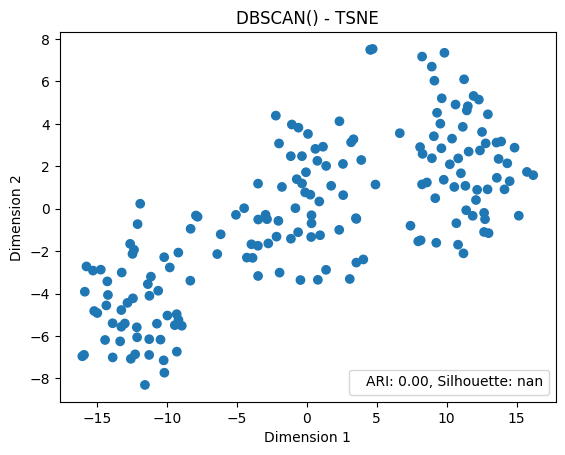

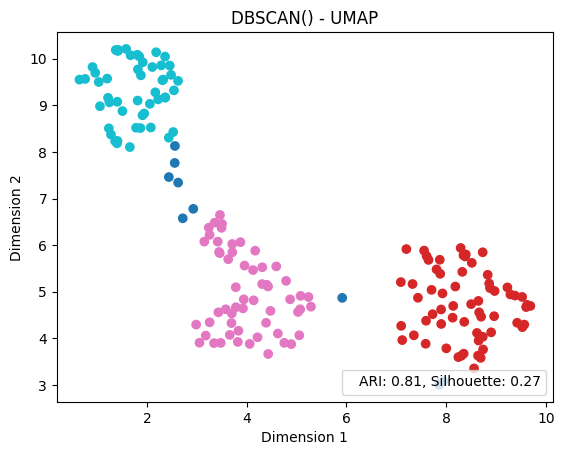

Algorithm: MeanShift()
Arguments:
	bandwidth: None
	bin_seeding: False
	cluster_all: True
	max_iter: 300
	min_bin_freq: 1
	n_jobs: None
	seeds: None


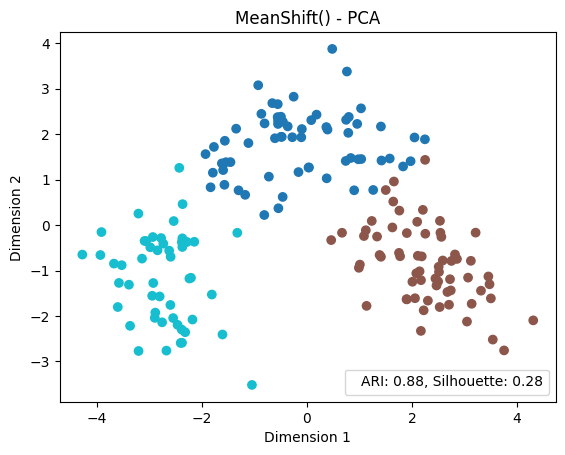

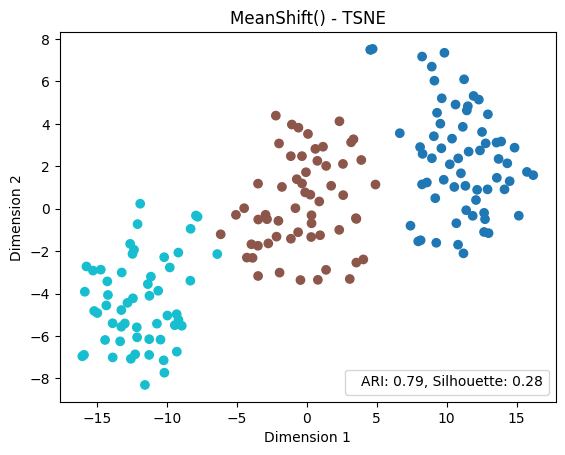

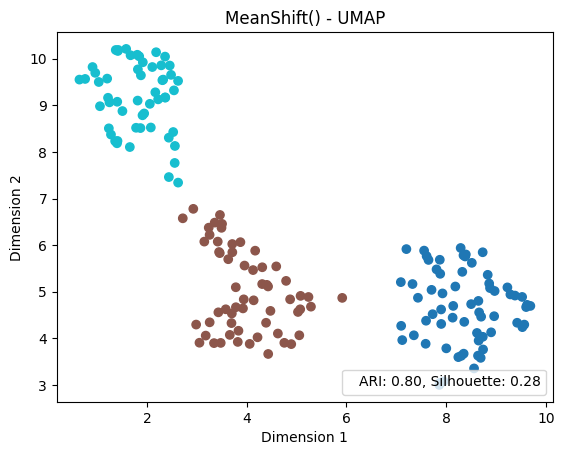

In [30]:
algorithms_without_n_clusters = [
    cluster.DBSCAN(eps=0.5, min_samples=5),  # вставлено просто так
    cluster.MeanShift(),
]

run_clustering(algorithms_without_n_clusters)

In [31]:
def plot_clusters_vs_hyperparameter(hyperparameter_values, n_clusters, ari_scores,
                                    silhouette_scores, hyperparameter_name, algorithm, reducer):
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel(hyperparameter_name)
    ax1.set_ylabel('Number of Clusters', color=color)
    ax1.plot(hyperparameter_values, n_clusters, 'bo-', label=f'Number of Clusters')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('ARI', color=color)
    ax2.plot(hyperparameter_values, ari_scores, 'ro-', label=f'ARI')
    ax2.tick_params(axis='y', labelcolor=color)

    ax3 = ax1.twinx()
    color = 'tab:green'
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Silhouette Score', color=color)
    ax3.plot(hyperparameter_values, silhouette_scores, 'go-', label=f'Silhouette Score')
    ax3.tick_params(axis='y', labelcolor=color)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    plt.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper right')

    plt.title(f'{algorithm} - {reducer}, varying {hyperparameter_name}')
    plt.grid(True)
    plt.show()

In [32]:
def plot_clustering_algorithm(
        X, y, clustering_algorithm,
        hyperparameter_name, hyperparameter_values,
        algorithm, reducer
):
    n_clusters_list = []
    ari_scores = []
    silhouette_scores = []

    for hyperparameter_value in hyperparameter_values:
        clustering_algorithm.set_params(**{hyperparameter_name: hyperparameter_value})

        labels, ari, silhouette = run_clustering_algorithm(clustering_algorithm, X, y)

        n_clusters = len(np.unique(labels))
        n_clusters_list.append(n_clusters)

        silhouette_scores.append(silhouette)
        ari_scores.append(ari)

    plot_clusters_vs_hyperparameter(hyperparameter_values, n_clusters_list, ari_scores,
                                    silhouette_scores, hyperparameter_name, algorithm, reducer)

In [33]:
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering

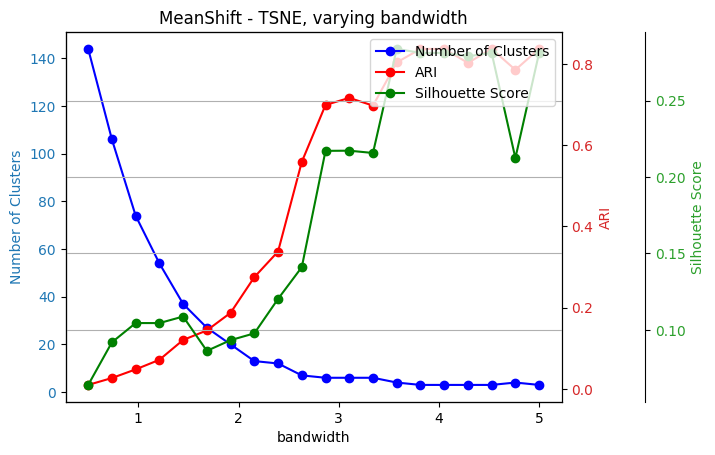

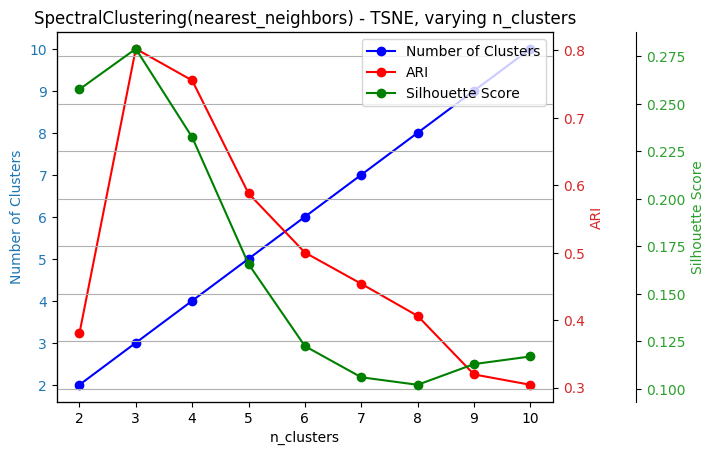

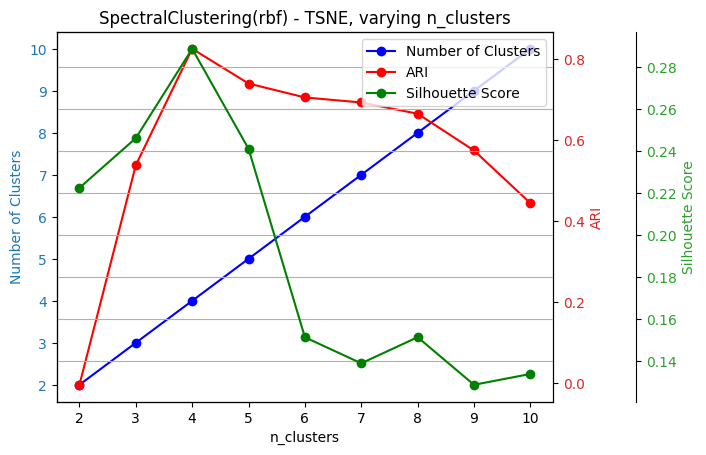

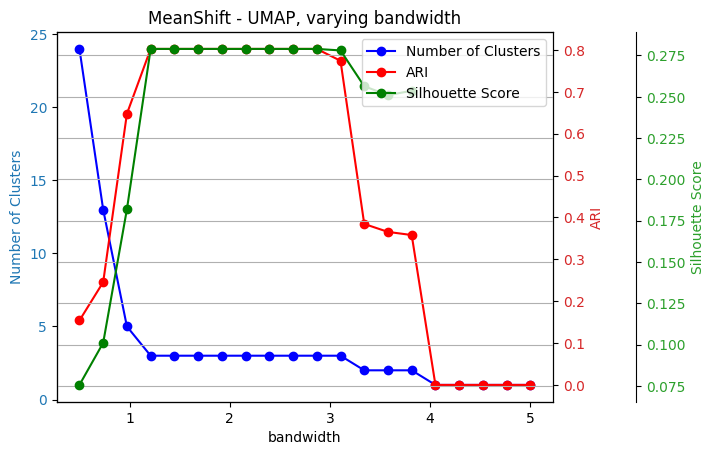

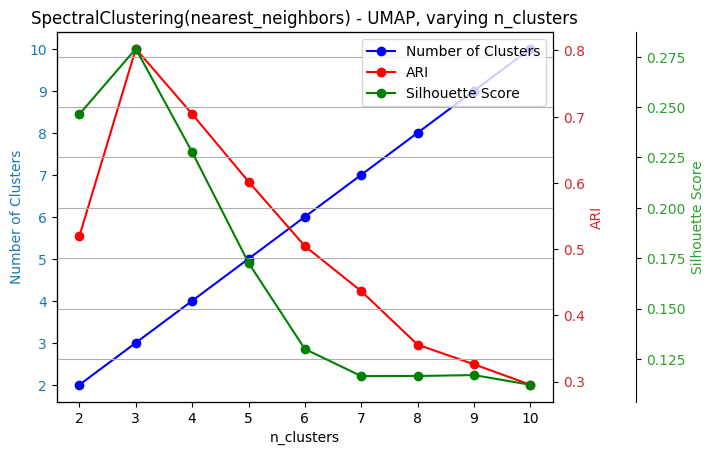

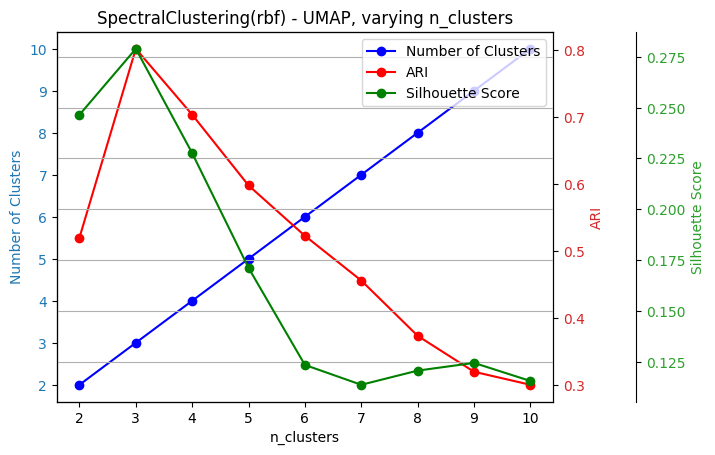

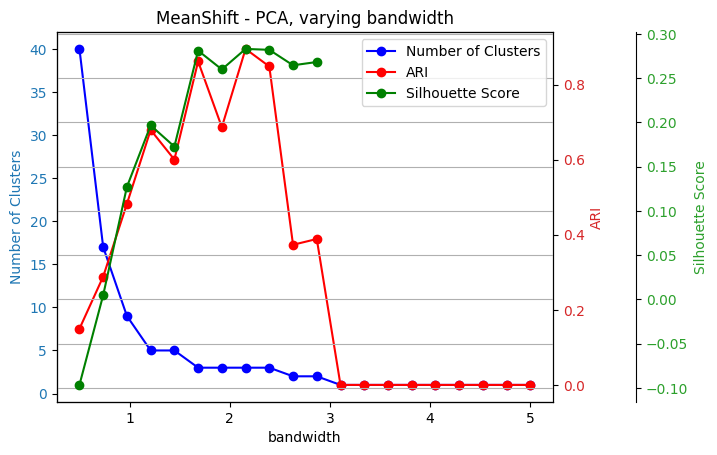

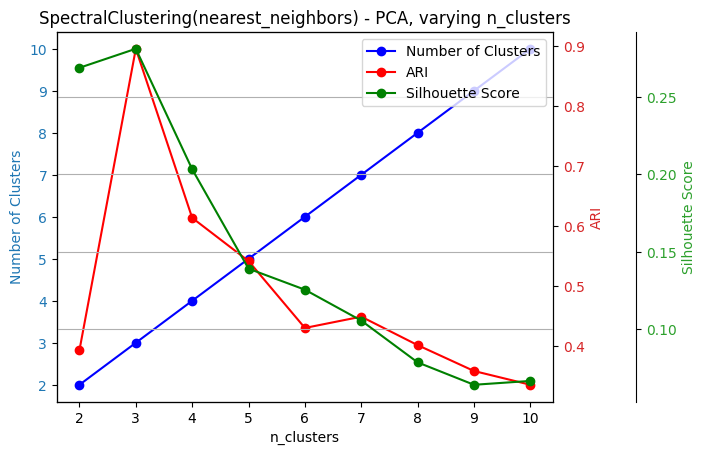

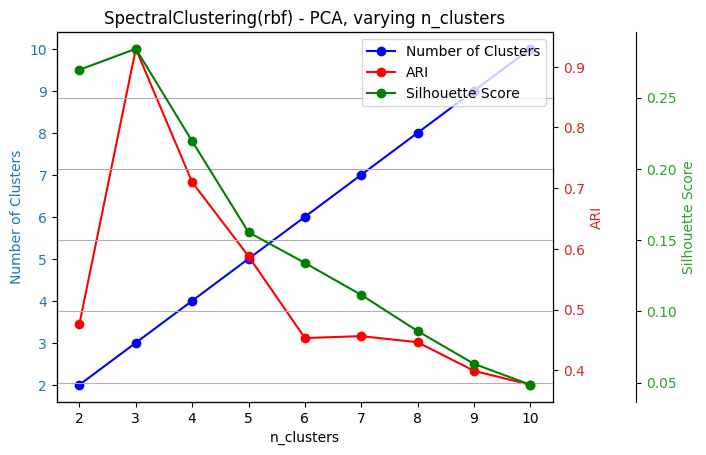

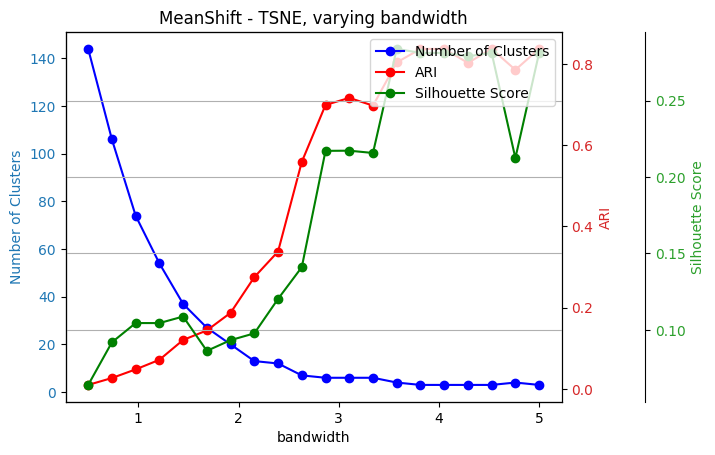

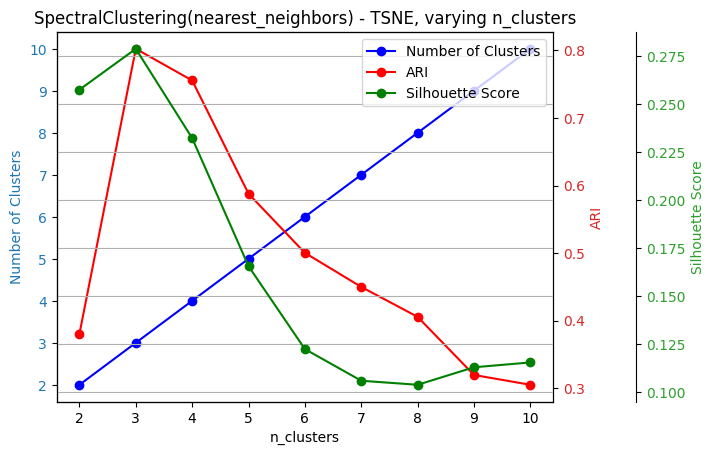

In [24]:
for reducer, X in X_reduced_list:
    plot_clustering_algorithm(
        X, y, MeanShift(),
        'bandwidth', np.linspace(0.5, 5, 20),
        'MeanShift', reducer
    )
    plot_clustering_algorithm(
        X, y, SpectralClustering(affinity='nearest_neighbors'),
        'n_clusters', range(2, 11),
        'SpectralClustering(nearest_neighbors)', reducer
    )
    plot_clustering_algorithm(
        X, y, SpectralClustering(affinity='rbf'),
        'n_clusters', range(2, 11),
        'SpectralClustering(rbf)', reducer
    )